# Abstract
### The objective of this notebook is to create a Generative Adverserial Network (GAN) with CelebA dataset - a dataset containing images of celebrities. The GAN's goal is to generate new images of faces that look as realistic as possible i.e., create fake faces that are most likely to look like a combination of celebrity faces. In the second half, some of the hyperparameters are tweaked so as to produce a different GAN output and compare the two.

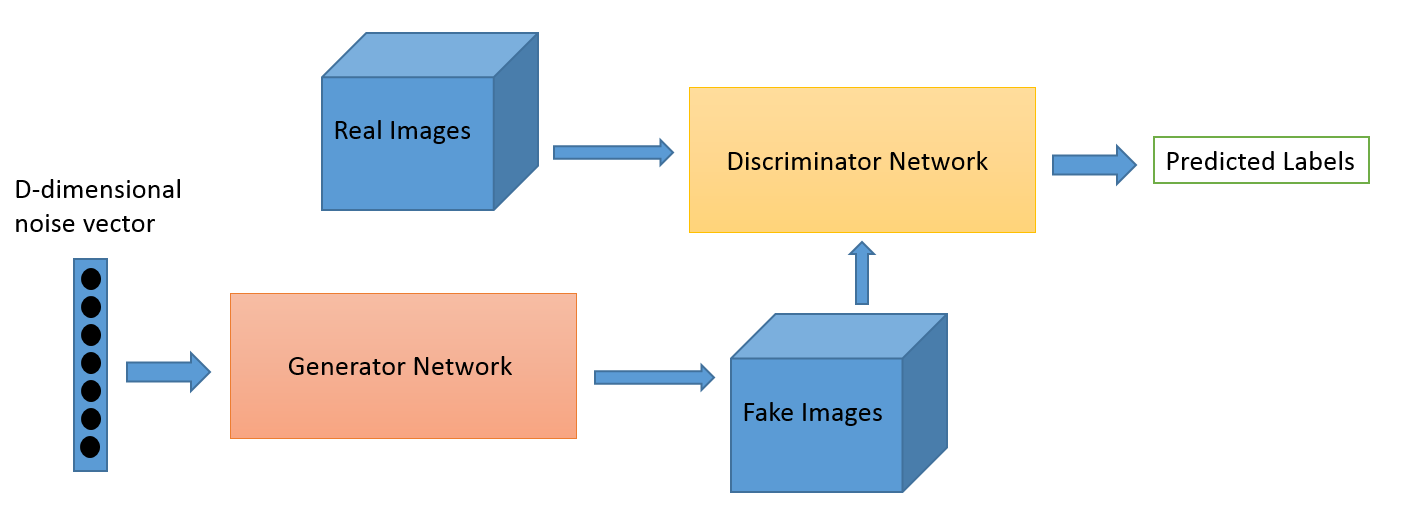

In [25]:
from IPython.display import Image
Image(filename='C:/Users/Karti/Downloads/gan_schema.png', width=600, height=600)

### The above picture shows a basic structure of a GAN. Real images are fed to the Discriminator and Noise is fed to the Generator. Notice the discriminator is fed both real and fake images. With that in mind, lets proceed to making our first GAN model. 

## Import Libraries

In [6]:
<hide>
from shutil import copyfile
</hide>

SyntaxError: invalid syntax (<ipython-input-6-2f8aa98aaf4e>, line 1)

In [57]:
copyfile

NameError: name 'copyfile' is not defined

In [ ]:
copyfile(src = "C:/Users/Karti/problem_unittests.py", dst = "../working/problem_unittests.py")

In [4]:
data_dir = '/NEU/data/processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
from unittest import test
import problem_unittests as tests
# import helper

%matplotlib inline

In [33]:
import torch
from torchvision import datasets
from torchvision import transforms

## Define Data loader function to load the data
#### Some transofrmation is done to the input images before it is fed to GAN

In [34]:
def get_dataloader(batch_size, image_size, data_dir='C:/Users/Karti/NEU/data/processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # This Below Code is written for Center Cropping the Images               
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        #transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])               
    
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    
    # TODO: Implement Function and Return a DataLoader
    image_transforms = transforms.Compose([transforms.Resize(image_size),
                                           transforms.ToTensor(),
                                          ])
    dataloader = torch.utils.data.DataLoader(datasets.ImageFolder(data_dir, transform=image_transforms)
                                             , shuffle=True, batch_size=batch_size)
    
    return dataloader

In [35]:
batch_size = 30
img_size = 32

# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

In [7]:
celeba_train_loader

### View a sample of images in our dataset

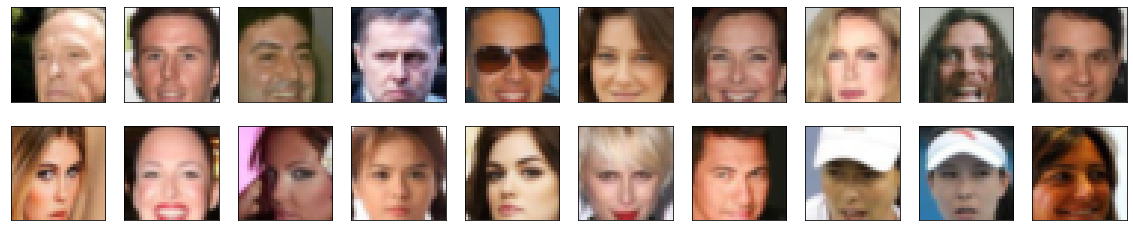

In [8]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [37]:
#Sace images to -1 to 1 range
def scale(x, feature_range=(-1, 1)):
    
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    
   # Print(x)
    x = x*(feature_range[1] - feature_range[0]) + feature_range[0]
 
    return x

In [10]:
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(1.)


In [2]:
import torch.nn as nn
import torch.nn.functional as F

### Below function is used to create a convolutional layer that is used in our network. All we need now is some input to the convolutional layer.

In [6]:
# Hepler Convoluitonal Function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    
    """
        Creates a Convolutional Layer, with Optional Batch Normalization.
    """
    
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # Append Convolutional Layer
    layers.append(conv_layer)

    if batch_norm:
        
        # Append Batch Normalization Layer
        layers.append(nn.BatchNorm2d(out_channels))
    
    # Using Sequential Container
    return nn.Sequential(*layers)

### The above convolutional layer is used in our Discriminator. The class for a Discriminator is defined below. At the end of the class definition, we call a function from "problem_unittests" that was imported earlier to test if our Discriminator is valid and passes certain pre-defined tests.

In [13]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # Define All Convolutional Layers
        # Should Accept RGB as Input & Output a Single Value
        
        # For Input of 32x32 & For First Layer, no batch_norm
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        
        # For Output of 16x16
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        
        # For Output of 8x8
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        
        # For Output of 4x4
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        
        # For Output of 2x2
        # Now Final, Fully-Connected Layer
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        
        # For Final Output Apply Sigmoid Activation Function
        self.out = nn.Sigmoid()
        
        # Apply Dropout If Needed
        self.dropout = nn.Dropout(0.5)

        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
       # Define Feed-Forward Behaviour
        # All Hidden Layers & ReLu Activation Function
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        
        # Flatten the Ouput
        out = out.view(-1, self.conv_dim*8*2*2)
        
        # Final Output Layer
        x = self.fc(out)
        
        # Return the Final Ouput
        return x


tests.test_discriminator(Discriminator)

Tests Passed


### Ok so Discrimator is ready! Let's move on to the Generator. For this, contrary to the convolutional layer used in Discriminator, we will use a deconvolutional layer. Function for deconvolutional layer is defined below

In [10]:
# For Deconvolutional Function

def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    
    layers=[]
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels,
                                             kernel_size, stride, padding, bias=False)
    
    # Append Transpose Convolutional Layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        
        # Append Batch Normalization Layer
        layers.append(nn.BatchNorm2d(out_channels))
    
    # Using Sequential Container
    return nn.Sequential(*layers)

### Let's put this function into the Generator class and test the Generator.

In [15]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # First, Fully-Connected Layer
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)

        # Transpose Covlolutional Layer
        self.deconv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.deconv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv3 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv4 = deconv(conv_dim, 3, 4, batch_norm=False)
        # print('z_size', z_size) Find what does this Means

    def forward(self, x):
        """
        Forward Propogation of the Neural Network
        :param x: The input to the Neural Network     
        :return: A 32x32x3 Tensor Image as Output
        """
        # Define Feed-Forward Behaviour
        # Fully-Connected Layer & Reshape the deconv Layer
        out = self.fc(x)
        
        # View the Ouput of the Fully-Connected & Reshape (batch_size, depth, 4, 4)
        out = out.view(-1, self.conv_dim*8, 2, 2)
        
        # Hidden Transpose Convolutional Layers
        # Apply the ReLu Activation Function Output
        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        out = F.relu(self.deconv3(out))
        
        # Last Layer of the deconv
        # Apply 'tanh' Activation Function to the Output
        out = self.deconv4(out)
        x = torch.tanh(out)
        
        # Return the Final Output
        return x

tests.test_generator(Generator)


Tests Passed


### All tests passed! Now that we have the Discriminator and Generator ready, we will initialize the weights and define our network.

In [24]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    
    # Classname will be something like: `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply Initial Weights to Convolutional & Linear Layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        m.weight.data.normal_(0.0, 0.02)
        
        # The Bias Terms, if they exist, Set to 0
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.zero_()
    

In [18]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


In [18]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (out): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(512, 25

In [30]:
import torch

# Check for a GPU if is Available
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


### We will now define a function to calculate the loss made by our Discriminator in order to monitor whether or not it does a good job in discriminating.

In [17]:
import random
from random import randrange, uniform

def real_loss(D_out, smooth=False):
    
    '''
    Calculates How Close Discriminator Outputs are to Being Real.
    param, D_out: Discriminator logits
    return: real loss
    '''
    batch_size = D_out.size(0)
    
    # Label Smoothing
    if smooth:
        # Smooth, Real Labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        # Real Labels = 1
        labels = torch.ones(batch_size)
    
    # Move Labels to GPU if is Available
    if train_on_gpu:
        labels = labels.cuda()
    
    # Binary Cross-Entropy with Logits Loss
    criterion = nn.BCEWithLogitsLoss()
    
    # Calculate Loss
    loss = criterion(D_out.squeeze(), labels)
    
    # Return the Calculated Loss
    return loss

def fake_loss(D_out):
    '''
    Calculates How Close Discriminator Outputs are to Being Fake.
    param, D_out: Discriminator Logits
    return: Fake Loss
    '''
    batch_size = D_out.size(0)
    
    # Fake Labels = 0
    labels = torch.zeros(batch_size)
    
    # Move Labels to GPU if is Available
    if train_on_gpu:
        labels = labels.cuda()
    
    # Binary Cross-Entropy with Logits Loss
    criterion = nn.BCEWithLogitsLoss()
    
    # Calculate Loss
    loss = criterion(D_out.squeeze(), labels)
    
    # Return the Calculated Loss
    return loss

### The loss optimizers are initialized for both Discriminator and Generator in order to help reduce the loss. Notice that Adam optimizer is used with the learning rate and beta values initialized.

In [21]:
import torch.optim as optim

# Create Optimizers for the Discriminator D and Generator G
d_optimizer = optim.Adam(D.parameters(), lr=0.0005, betas=(0.4, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=0.0005, betas=(0.4, 0.999))

### Ok now we are all set to train our network. The below function is defined such that it takes the Discriminator, Generator and number of epochs as input. The output generator samples as saved in a training_samples file.

In [28]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            
            d_optimizer.zero_grad()
            
            # Check If GPU is Available
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # 1. Train the Discriminator on Real and Fake Images
            
            # Compute the Discriminator Losses on Real Images
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # Generate Fake Images
            z_fake = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z_fake = torch.from_numpy(z_fake).float()
            
            # Move to GPU if is Available
            if train_on_gpu:
                z_fake = z_fake.cuda()
            fake_images = G(z_fake)
            
            # Compute the Discriminator Losses on Fake Images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # Add Up Loss and Perform Back Propagation
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the Generator with an Adversarial Loss
            g_optimizer.zero_grad()
            
            # Generate Fake Images
            z_fake = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z_fake = torch.from_numpy(z_fake).float()
            
            # Check If GPU is Available
            if train_on_gpu:
                z_fake = z_fake.cuda()
            fake_images = G(z_fake)
            
            # Compute the Discriminator Losses on Fake Images
            D_fake = D(fake_images)
            
            # Use Real Loss to Flip Labels
            g_loss = real_loss(D_fake, True)
            
            # Perform Back Propagation
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print Some Loss Stats
            if batch_i % print_every == 0:
                
                # Append Discriminator Loss and Generator Loss
                losses.append((d_loss.item(), g_loss.item()))
                
                # Print Discriminator and Generator Loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


      
        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [23]:
# set number of epochs 
n_epochs = 20


# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   20] | d_loss: 1.4153 | g_loss: 4.4221
Epoch [    1/   20] | d_loss: 0.8892 | g_loss: 5.2344
Epoch [    1/   20] | d_loss: 1.4146 | g_loss: 4.5727
Epoch [    1/   20] | d_loss: 0.7768 | g_loss: 1.7500
Epoch [    1/   20] | d_loss: 1.1429 | g_loss: 4.8388
Epoch [    1/   20] | d_loss: 1.5077 | g_loss: 0.7180
Epoch [    1/   20] | d_loss: 0.8301 | g_loss: 2.0931
Epoch [    1/   20] | d_loss: 0.7443 | g_loss: 2.2710
Epoch [    1/   20] | d_loss: 0.9921 | g_loss: 2.1364
Epoch [    1/   20] | d_loss: 0.9299 | g_loss: 1.5832
Epoch [    1/   20] | d_loss: 0.8905 | g_loss: 1.4014
Epoch [    1/   20] | d_loss: 0.9664 | g_loss: 2.4645
Epoch [    1/   20] | d_loss: 1.6931 | g_loss: 3.3785
Epoch [    1/   20] | d_loss: 1.0931 | g_loss: 2.0619
Epoch [    1/   20] | d_loss: 1.2040 | g_loss: 1.4294
Epoch [    1/   20] | d_loss: 1.5195 | g_loss: 1.3826
Epoch [    1/   20] | d_loss: 1.2478 | g_loss: 2.0785
Epoch [    2/   20] | d_loss: 2.2967 | g_loss: 1.2610
Epoch [    2/   20] | d_loss

Epoch [    9/   20] | d_loss: 1.2815 | g_loss: 1.8458
Epoch [   10/   20] | d_loss: 0.7213 | g_loss: 2.1858
Epoch [   10/   20] | d_loss: 0.9304 | g_loss: 1.1366
Epoch [   10/   20] | d_loss: 1.2208 | g_loss: 2.1399
Epoch [   10/   20] | d_loss: 0.8322 | g_loss: 1.9086
Epoch [   10/   20] | d_loss: 0.8696 | g_loss: 1.7782
Epoch [   10/   20] | d_loss: 1.5596 | g_loss: 3.6499
Epoch [   10/   20] | d_loss: 1.1765 | g_loss: 2.9903
Epoch [   10/   20] | d_loss: 0.8604 | g_loss: 2.5164
Epoch [   10/   20] | d_loss: 0.9990 | g_loss: 1.8397
Epoch [   10/   20] | d_loss: 1.0469 | g_loss: 2.1207
Epoch [   10/   20] | d_loss: 0.8914 | g_loss: 1.9766
Epoch [   10/   20] | d_loss: 0.7872 | g_loss: 2.5818
Epoch [   10/   20] | d_loss: 0.7219 | g_loss: 2.5627
Epoch [   10/   20] | d_loss: 0.6004 | g_loss: 2.6564
Epoch [   10/   20] | d_loss: 0.4571 | g_loss: 1.8137
Epoch [   10/   20] | d_loss: 0.7878 | g_loss: 2.6854
Epoch [   10/   20] | d_loss: 0.9235 | g_loss: 3.5237
Epoch [   11/   20] | d_loss

Epoch [   18/   20] | d_loss: 0.6023 | g_loss: 1.5979
Epoch [   18/   20] | d_loss: 0.2921 | g_loss: 2.9241
Epoch [   19/   20] | d_loss: 1.1301 | g_loss: 5.1224
Epoch [   19/   20] | d_loss: 0.5874 | g_loss: 3.2109
Epoch [   19/   20] | d_loss: 0.2724 | g_loss: 4.4346
Epoch [   19/   20] | d_loss: 0.5073 | g_loss: 2.6121
Epoch [   19/   20] | d_loss: 0.4770 | g_loss: 4.1967
Epoch [   19/   20] | d_loss: 0.2837 | g_loss: 2.7232
Epoch [   19/   20] | d_loss: 0.1735 | g_loss: 3.2551
Epoch [   19/   20] | d_loss: 0.4656 | g_loss: 2.0881
Epoch [   19/   20] | d_loss: 0.3906 | g_loss: 3.3468
Epoch [   19/   20] | d_loss: 0.7862 | g_loss: 1.1086
Epoch [   19/   20] | d_loss: 1.1310 | g_loss: 1.6561
Epoch [   19/   20] | d_loss: 0.1552 | g_loss: 2.1172
Epoch [   19/   20] | d_loss: 0.3102 | g_loss: 4.3844
Epoch [   19/   20] | d_loss: 0.2331 | g_loss: 3.4860
Epoch [   19/   20] | d_loss: 0.2135 | g_loss: 3.8667
Epoch [   19/   20] | d_loss: 0.4658 | g_loss: 1.9248
Epoch [   19/   20] | d_loss

### The losses for Discriminator & Generator are plotted below:

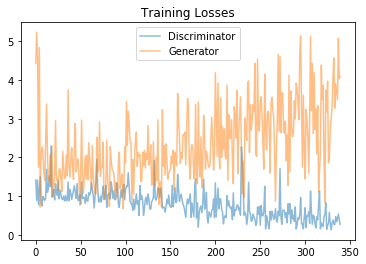

In [24]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [40]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [26]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

### Lets view our output i.e., Fake Celebrity Faces! (whatever that means!)

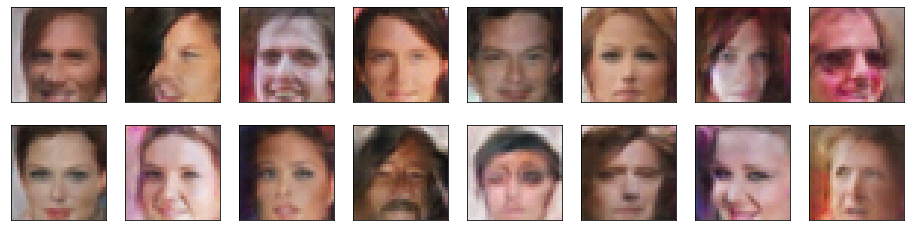

In [27]:
_ = view_samples(-1, samples)

# MODIFIED GAN - MODEL 2

### Now that we have an initial model, let's tune some hyperparameters to see how they affect our network. First, we will define a new Discriminator network. Notice that the Dropout after the Sigmoid has changed from 0.5 to 0.2. Also, the activation of output has changed from leaky_relu to relu and the slope for that has also been updated. The new class is then put through a similar test as in the first iteration.

In [9]:
class DiscriminatorNew(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(DiscriminatorNew, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # Define All Convolutional Layers
        # Should Accept RGB as Input & Output a Single Value
        
        # For Input of 32x32 & For First Layer, no batch_norm
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        
        # For Output of 16x16
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        
        # For Output of 8x8
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        
        # For Output of 4x4
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        
        # For Output of 2x2
        # Now Final, Fully-Connected Layer
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        
        # For Final Output Apply Sigmoid Activation Function
        self.out = nn.Sigmoid()
        
        # Apply Dropout If Needed
        self.dropout = nn.Dropout(0.2) #droput changed to 0.2 from 0.5

        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
       # Define Feed-Forward Behaviour
        # All Hidden Layers & ReLu Activation Function
        out = F.relu(self.conv1(x), 0.1)
        out = F.relu(self.conv2(out), 0.1)
        out = F.relu(self.conv3(out), 0.1)
        out = F.relu(self.conv4(out), 0.1)
        
        # Flatten the Ouput
        out = out.view(-1, self.conv_dim*8*2*2)
        
        # Final Output Layer
        x = self.fc(out)
        
        # Return the Final Ouput
        return x


tests.test_discriminator(DiscriminatorNew)

Tests Passed


### Now, we modify the Generator class. Here, we change the earlier 'relu' activation to 'leaky-relu' and tanh to 'leaky-relu' 

In [14]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # First, Fully-Connected Layer
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)

        # Transpose Covlolutional Layer
        self.deconv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.deconv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv3 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv4 = deconv(conv_dim, 3, 4, batch_norm=False)
        # print('z_size', z_size) Find what does this Means

    def forward(self, x):
        """
        Forward Propogation of the Neural Network
        :param x: The input to the Neural Network     
        :return: A 32x32x3 Tensor Image as Output
        """
        # Define Feed-Forward Behaviour
        # Fully-Connected Layer & Reshape the deconv Layer
        out = self.fc(x)
        
        # View the Ouput of the Fully-Connected & Reshape (batch_size, depth, 4, 4)
        out = out.view(-1, self.conv_dim*8, 2, 2)
        
        # Hidden Transpose Convolutional Layers
        # Apply the ReLu Activation Function Output
        out = F.leaky_relu(self.deconv1(out))
        out = F.leaky_relu(self.deconv2(out))
        out = F.leaky_relu(self.deconv3(out))
        
        # Last Layer of the deconv
        # Apply 'tanh' Activation Function to the Output
        out = self.deconv4(out)
        x = F.leaky_relu(out)
        
        # Return the Final Output
        return x

tests.test_generator(Generator)


Tests Passed


### Let's build the new network

In [21]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    
    # define discriminator and generator
    D = DiscriminatorNew(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


In [25]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

DiscriminatorNew(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (out): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(512,

### Loss optimizers are changed to the below values:

In [26]:
import torch.optim as optim

# Create Optimizers for the Discriminator D and Generator G
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

### Time to train the network

In [49]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            
            d_optimizer.zero_grad()
            
            # Check If GPU is Available
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # 1. Train the Discriminator on Real and Fake Images
            
            # Compute the Discriminator Losses on Real Images
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # Generate Fake Images
            z_fake = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z_fake = torch.from_numpy(z_fake).float()
            
            # Move to GPU if is Available
            if train_on_gpu:
                z_fake = z_fake.cuda()
            fake_images = G(z_fake)
            
            # Compute the Discriminator Losses on Fake Images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # Add Up Loss and Perform Back Propagation
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the Generator with an Adversarial Loss
            g_optimizer.zero_grad()
            
            # Generate Fake Images
            z_fake = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z_fake = torch.from_numpy(z_fake).float()
            
            # Check If GPU is Available
            if train_on_gpu:
                z_fake = z_fake.cuda()
            fake_images = G(z_fake)
            
            # Compute the Discriminator Losses on Fake Images
            D_fake = D(fake_images)
            
            # Use Real Loss to Flip Labels
            g_loss = real_loss(D_fake, True)
            
            # Perform Back Propagation
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print Some Loss Stats
            if batch_i % print_every == 0:
                
                # Append Discriminator Loss and Generator Loss
                losses.append((d_loss.item(), g_loss.item()))
                
                # Print Discriminator and Generator Loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


      
        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples_new.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [50]:
# set number of epochs 
n_epochs = 20


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   20] | d_loss: 0.0372 | g_loss: 4.4241
Epoch [    1/   20] | d_loss: 9.4597 | g_loss: 8.4456
Epoch [    1/   20] | d_loss: 0.0407 | g_loss: 4.3226
Epoch [    1/   20] | d_loss: 0.0341 | g_loss: 4.3721
Epoch [    1/   20] | d_loss: 0.0136 | g_loss: 5.4056
Epoch [    1/   20] | d_loss: 0.3028 | g_loss: 1.9928
Epoch [    1/   20] | d_loss: 0.0209 | g_loss: 5.9246
Epoch [    1/   20] | d_loss: 0.0129 | g_loss: 7.5301
Epoch [    1/   20] | d_loss: 0.0186 | g_loss: 5.3823
Epoch [    1/   20] | d_loss: 0.3573 | g_loss: 9.1476
Epoch [    1/   20] | d_loss: 0.0251 | g_loss: 5.6723
Epoch [    1/   20] | d_loss: 0.1097 | g_loss: 8.7148
Epoch [    1/   20] | d_loss: 0.0833 | g_loss: 3.8394
Epoch [    1/   20] | d_loss: 0.0382 | g_loss: 5.2786
Epoch [    1/   20] | d_loss: 0.0795 | g_loss: 2.9049
Epoch [    1/   20] | d_loss: 0.1347 | g_loss: 6.0608
Epoch [    1/   20] | d_loss: 0.0468 | g_loss: 2.3314
Epoch [    2/   20] | d_loss: 0.0060 | g_loss: 5.7175
Epoch [    2/   20] | d_loss

Epoch [    9/   20] | d_loss: 0.0014 | g_loss: 5.8136
Epoch [   10/   20] | d_loss: 0.0018 | g_loss: 5.4439
Epoch [   10/   20] | d_loss: 0.0002 | g_loss: 5.6714
Epoch [   10/   20] | d_loss: 0.0014 | g_loss: 5.0247
Epoch [   10/   20] | d_loss: 0.0049 | g_loss: 7.1836
Epoch [   10/   20] | d_loss: 0.1793 | g_loss: 1.9014
Epoch [   10/   20] | d_loss: 0.0404 | g_loss: 3.7940
Epoch [   10/   20] | d_loss: 0.7391 | g_loss: 8.8611
Epoch [   10/   20] | d_loss: 0.0653 | g_loss: 4.3504
Epoch [   10/   20] | d_loss: 0.0251 | g_loss: 5.0373
Epoch [   10/   20] | d_loss: 0.0069 | g_loss: 5.4508
Epoch [   10/   20] | d_loss: 0.0146 | g_loss: 4.4598
Epoch [   10/   20] | d_loss: 0.0089 | g_loss: 5.2709
Epoch [   10/   20] | d_loss: 3.0815 | g_loss: 10.7127
Epoch [   10/   20] | d_loss: 0.0700 | g_loss: 3.1165
Epoch [   10/   20] | d_loss: 0.0027 | g_loss: 5.2889
Epoch [   10/   20] | d_loss: 0.0418 | g_loss: 4.8026
Epoch [   10/   20] | d_loss: 0.0099 | g_loss: 5.9986
Epoch [   11/   20] | d_los

Epoch [   18/   20] | d_loss: 0.0153 | g_loss: 5.5414
Epoch [   18/   20] | d_loss: 0.1232 | g_loss: 3.7457
Epoch [   19/   20] | d_loss: 0.0110 | g_loss: 6.6542
Epoch [   19/   20] | d_loss: 0.0404 | g_loss: 4.7327
Epoch [   19/   20] | d_loss: 0.3721 | g_loss: 8.7117
Epoch [   19/   20] | d_loss: 0.0208 | g_loss: 2.8912
Epoch [   19/   20] | d_loss: 0.0185 | g_loss: 4.0067
Epoch [   19/   20] | d_loss: 0.0565 | g_loss: 4.7542
Epoch [   19/   20] | d_loss: 0.0175 | g_loss: 5.2295
Epoch [   19/   20] | d_loss: 0.0072 | g_loss: 4.8860
Epoch [   19/   20] | d_loss: 0.0021 | g_loss: 5.4882
Epoch [   19/   20] | d_loss: 1.3154 | g_loss: 14.6216
Epoch [   19/   20] | d_loss: 0.0372 | g_loss: 4.3090
Epoch [   19/   20] | d_loss: 0.0100 | g_loss: 4.0899
Epoch [   19/   20] | d_loss: 0.0120 | g_loss: 4.7410
Epoch [   19/   20] | d_loss: 3.0912 | g_loss: 8.7891
Epoch [   19/   20] | d_loss: 0.0191 | g_loss: 3.7357
Epoch [   19/   20] | d_loss: 0.0073 | g_loss: 5.6064
Epoch [   19/   20] | d_los

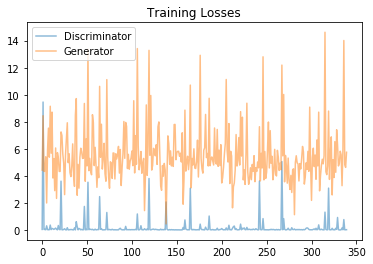

In [52]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Notice how the losses have gone up for both the Discriminator and Generator. In the earlier model, the Generator would only go up to a value of 5 and the Discriminator was close to 0. Here, the Generator loss goes up to 14+ and the Discriminator also goes upto 6 in some cases. 

In [55]:
with open('train_samples_new.pkl', 'rb') as f:
    samples = pkl.load(f)

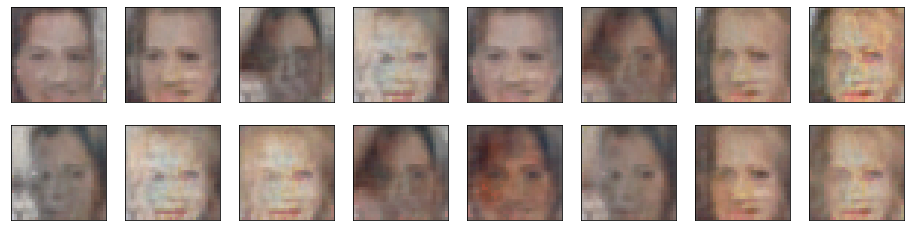

In [56]:
_ = view_samples(-1, samples)

### The new output looks like it can be used for horror movies! A drop in the performance has indeed taken place by our network. This shows that although we reduced the learning rate hoping the network would learn better, the loss functions used made a huge difference and can make or break the output of our model. Here's an article that I highly recommend in order to understand which are the common alternate loss functions that can be used.

# Conclusion:
### In conclusion, this notebook helped give a small introduction to how GANs are structured and how their performance can be tweaked. The Discriminator and Generator play a huge role deciding the performance of a GAN and form it's core. In the above sample, Model A worked better than B as it learnt more features in the discriminator and generated faces from learning how to differentiate those features.

Important Citations:
https://www.kaggle.com/vivekdave/gan-generate-faces 
https://machinelearningmastery.com/generative-adversarial-network-loss-functions/
https://hackernoon.com/how-do-gans-intuitively-work-2dda07f247a1

Copyright 2020 Kartik Kumar

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.